## Analysis of spam SMS messages (data from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/))

In [ ]:
!conda list

In [ ]:
!pip install seaborn

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df=pd.read_csv('data/SMSSpamCollection',sep='\t',header=None,names=['class','text'])

In [3]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df['text_len'] = df['text'].apply(len)

In [5]:
df.head()

,class,text,text_len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [6]:
pd.set_option('display.max_colwidth', 500)

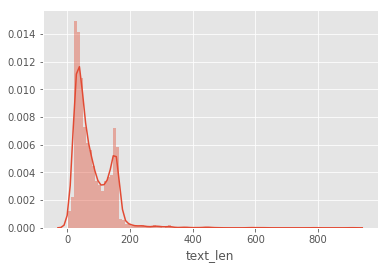

In [7]:
sns.distplot(df.text_len,bins='auto')

In [8]:
df['class'].value_counts()

ham     4825
spam     747
Name: class, dtype: int64

In [9]:
spam = df['class'] == 'spam'
df_spam = df[spam]


ham = df['class'] == 'ham'
df_ham = df[ham]


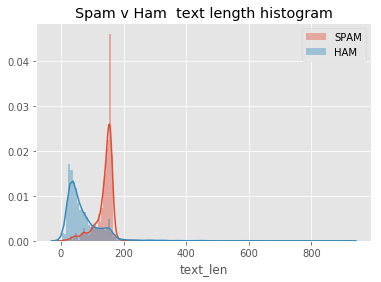

In [10]:
sns.distplot(df_spam.text_len,bins='auto',label='SPAM')
sns.distplot(df_ham.text_len,bins='auto',label='HAM')
plt.legend()
plt.title('Spam v Ham  text length histogram')
plt.show()

## Split into test data and training data

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.25)

## Some Pre-processing

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer

In [14]:
count_vect = CountVectorizer()

In [15]:
X_train_counts = count_vect.fit_transform(X_train)

In [16]:
X_train_counts

<4179x7504 sparse matrix of type '<class 'numpy.int64'>'
	with 55456 stored elements in Compressed Sparse Row format>

In [17]:
list(count_vect.vocabulary_.items())[:10]

[('no', 4644),
 ('objection', 4722),
 ('my', 4518),
 ('bf', 1291),
 ('not', 4678),
 ('coming', 1848),
 ('it', 3636),
 ('pride', 5235),
 ('almost', 889),
 ('lt', 4109)]

In [18]:
list(count_vect.vocabulary_.items())[-10:]

[('09066368753', 221),
 ('97n7qp', 704),
 ('filthyguys', 2768),
 ('slo', 6019),
 ('4msgs', 505),
 ('answers', 957),
 ('ques', 5346),
 ('suits', 6353),
 ('discussed', 2285),
 ('half8th', 3207)]

In [19]:
len(count_vect.vocabulary_)

7504

In [20]:
lab_bin=LabelBinarizer()
y_train_bin=lab_bin.fit_transform(y_train)  # converts 'ham' 'spam' to 0,1
y_test_bin=lab_bin.fit_transform(y_test)   # converts 'ham' 'spam' to 0,1

In [21]:
type(y_train_bin)

numpy.ndarray

In [22]:
ravel?

Object `ravel` not found.


In [23]:
y_train_bin.ravel()  # Return a contiguous flattened array.


array([0, 0, 0, ..., 0, 0, 0])

## Train

In [24]:
from sklearn.naive_bayes import MultinomialNB

In [25]:
clf = MultinomialNB()

In [26]:
clf.fit(X_train_counts, y_train_bin.ravel())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
len(clf.coef_[0])

7504

In [28]:
import collections

In [29]:
importanceCount=collections.Counter()

In [30]:
for word,imp in zip(count_vect.vocabulary_.keys(),clf.coef_[0]):
    importanceCount[word]=imp

In [31]:
importanceCount.most_common()[:10]

[('hesitate', -3.678546327996287),
 ('messenger', -4.3450252614740705),
 ('yoyyooo', -4.534894023903408),
 ('saeed', -4.605511591117361),
 ('soryda', -4.828655142431571),
 ('maretare', -4.872275764907462),
 ('pura', -4.917886276159514),
 ('certainly', -4.931309296491655),
 ('belongs', -4.994047637125078),
 ('cruise', -5.100207832953468)]

In [32]:
importanceCount.most_common()[-10:]

[('christmassy', -9.92852157025577),
 ('t4get2text', -9.92852157025577),
 ('cloth', -9.92852157025577),
 ('09066368753', -9.92852157025577),
 ('97n7qp', -9.92852157025577),
 ('slo', -9.92852157025577),
 ('4msgs', -9.92852157025577),
 ('ques', -9.92852157025577),
 ('suits', -9.92852157025577),
 ('half8th', -9.92852157025577)]

## Now test

In [33]:
X_test_counts = count_vect.transform(X_test)

In [34]:
pred=clf.predict(X_test_counts)

In [35]:
from sklearn.metrics import average_precision_score

In [36]:
average_precision_score(y_test_bin,pred)

0.917761513687498

## Sanity check

In [37]:
clf.predict(count_vect.transform(['win big on this offer']))

array([1])

In [38]:
clf.predict(count_vect.transform(['hi how are you? shall we meet up soon?']))

array([0])

In [39]:
clf.predict_proba(count_vect.transform(['hi how are you? shall we meet up soon?']))

array([[9.99999464e-01, 5.35958971e-07]])

In [40]:
clf.predict(count_vect.transform(['Hey why wondt you reply my text?']))

array([0])

In [41]:
clf.predict_proba(count_vect.transform(['Cheap viagra']))

array([[0.71042291, 0.28957709]])

In [42]:
clf

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
clf.predict_proba(count_vect.transform(['hi how are you? shall we meet up soon?']))

array([[9.99999464e-01, 5.35958971e-07]])